# Predict Credit Scoring

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

## Условия соревнования:
- Данное соревнование является бессрочным и доступно для всех потоков.
- Срок выполнения соревнования устанавливается индивидуально в каждом потоке.
- Тестовая выборка представлена в ЛидерБорде целиком.
- Поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).
- Разрешено использовать любые ML алгоритмы и библиотеки (кроме DL).
- Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

# Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # библиотека для работы с файлами csv
import numpy as np # линейная алгебра

# Библиотеки для визулизации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Библиотеки для обработки признаков
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Библиотеки для работы с ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Библиотеки метрик
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import zscore

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [10]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения defaultg, мы его должны предсказать, по этому пока просто заполняем -1

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Описания полей

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [13]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
51473,81808,29MAR2014,SCH,F,27,Y,N,0,0,-1.855187,1,80,2,2,90000,2,2,Y,1,0
34751,82044,30MAR2014,SCH,F,35,N,N,0,0,-2.234677,1,40,1,2,5000,1,4,N,0,-1
104528,86725,03APR2014,GRD,F,34,Y,Y,1,0,-1.091885,1,60,2,3,35000,2,3,N,1,0
53675,91645,08APR2014,SCH,M,60,N,N,0,0,-2.442710,1,40,2,3,13500,1,3,N,1,0
5942,9482,16JAN2014,SCH,M,53,N,N,0,0,-1.775263,5,60,2,3,20000,4,1,N,0,-1


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

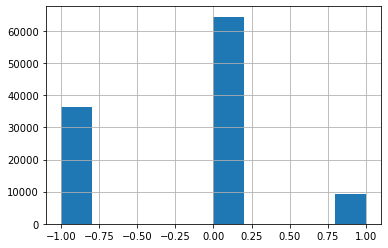

In [14]:
data.default.hist()

## Data Processing

### Обработка NAN

In [15]:
data.isnull().sum(axis = 0)

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

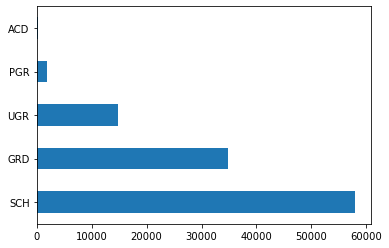

In [16]:
data.education.value_counts().plot.barh()


Давайте заполним его "unknown" значением

In [17]:
data['education'].fillna('UNK', inplace=True)

### Обработка признаков

Так ка ранее мы уже обрабатывали большинство признаков и знаем к какой категории они относятся, посмотрим внимательнее новые признаки.

In [18]:
data.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

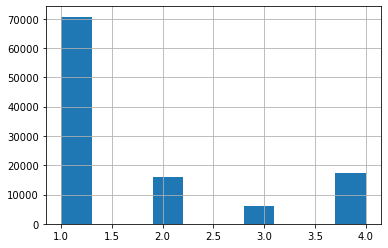

In [19]:
data.sna.hist()

In [20]:
data.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

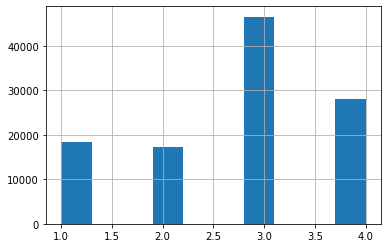

In [21]:
data.first_time.hist()

In [22]:
data.score_bki.value_counts()

-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
            ... 
-1.916044      1
-2.142259      1
-1.227466      1
-2.709566      1
-2.295169      1
Name: score_bki, Length: 102618, dtype: int64

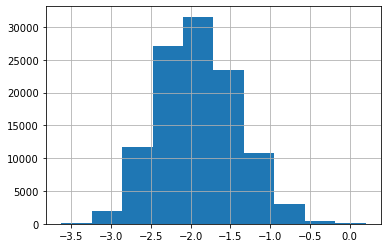

In [23]:
data.score_bki.hist()

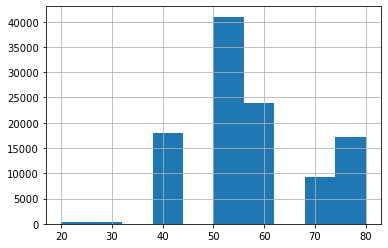

In [24]:
data.region_rating.hist()

In [25]:
data.app_date.head(5)

0    22MAR2014
1    24JAN2014
2    23MAR2014
3    03FEB2014
4    04FEB2014
Name: app_date, dtype: object

Преобразование app_date в тип datetime

In [26]:
data.app_date = pd.to_datetime(data.app_date)
data.app_date.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

Для дальнейшей работы можем выделить из данного признака новые, такие как: месяц и день недели. Год рассматривать нет смысла, так как мы видим, что и ранняя и поздняя даты за 2014г.

In [27]:
data["app_day_month"] = data.app_date.dt.month 

In [28]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day_month
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,...,50,1,2,50000,1,4,N,0,-1,3
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,...,50,1,2,5000,4,3,N,0,-1,1
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,...,50,1,2,30000,1,3,Y,0,-1,3
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,...,40,1,2,17000,1,3,N,0,-1,2
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,...,80,2,3,120000,1,3,N,0,-1,2


In [29]:
data["app_day_month"].value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_day_month, dtype: int64

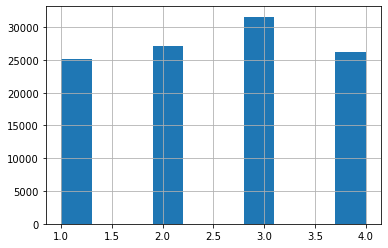

In [30]:
data["app_day_month"].hist()

Группируем признаки

In [31]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_day_month']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'region_rating', 'bki_request_cnt', 'income']

## Числовые признаки

#### Посмотрим на распределение числовых переменных

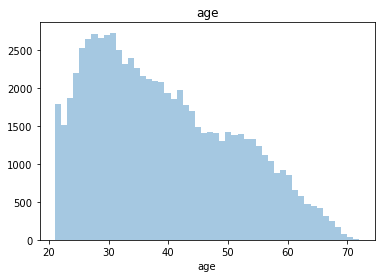

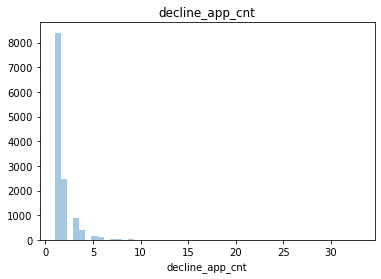

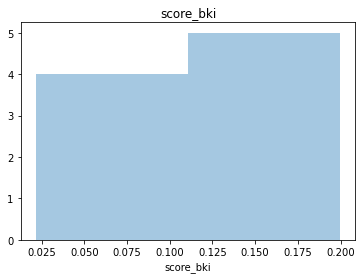

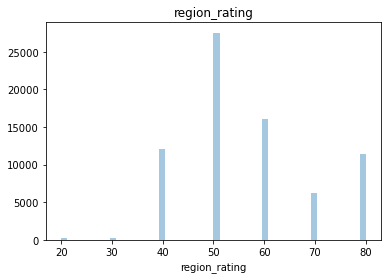

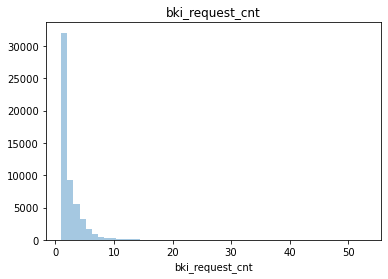

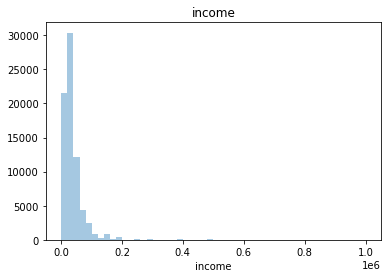

In [32]:
data_default = data[data.default >= 0]
for i in num_cols:
    plt.figure()
    sns.distplot(data_default[i][data_default[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

У большинства параметров видим большой хвост справа, для лучшей работы нашей будущей модели логарифмируем параметры.

In [33]:
for i in ['age', 'decline_app_cnt', 'region_rating', 'bki_request_cnt', 'income']:
    data[i] = np.log(data[i] + 1)

Посмотрим на boxplot числовых переменных по целевому параметру. А так же корреляцию.

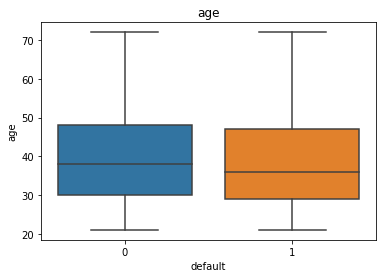

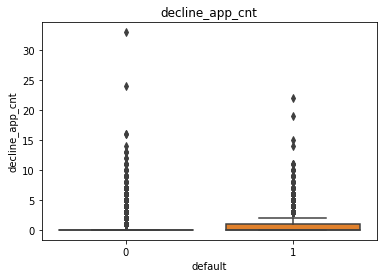

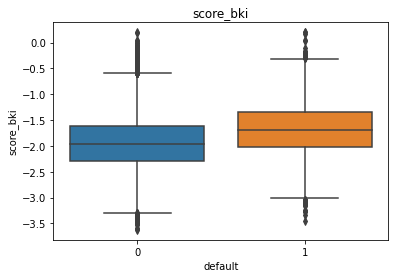

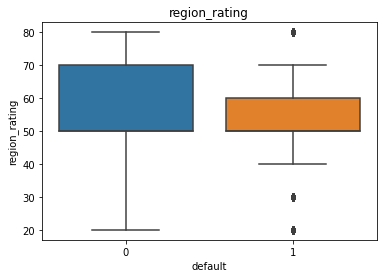

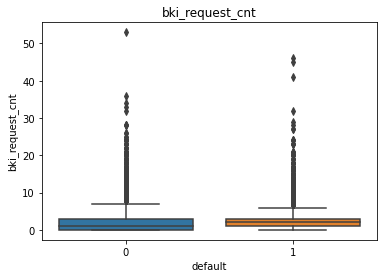

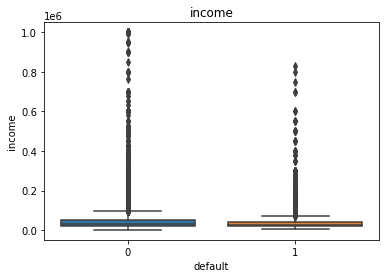

In [34]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x='default', y=i, data=data_default)
    plt.title(i)
    plt.show()

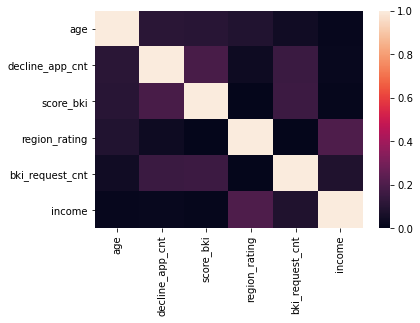

In [35]:
sns.heatmap(data_default[num_cols].corr().abs(), vmin=0, vmax=1)

Как мы видим, коррекляция между признакаи минимальна.

Для оценки значимости числовых переменных будем использовать функцию f_classif. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

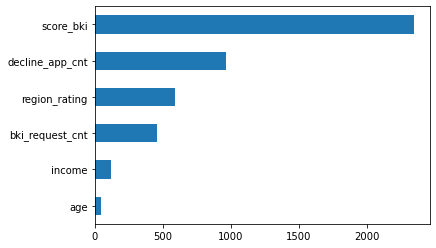

In [36]:
imp_num = pd.Series(f_classif(data_default[num_cols], data_default['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Бинарные признаки

In [38]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day_month
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,3.931826,1,2,10.819798,1,4,0,0,-1,3
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,3.931826,1,2,8.517393,4,3,0,0,-1,1
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,3.931826,1,2,10.308986,1,3,1,0,-1,3
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,3.713572,1,2,9.741027,1,3,0,0,-1,2
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,4.394449,2,3,11.695255,1,3,0,0,-1,2


## Категорианльные признаки

In [39]:
# Преобразуем данные в числа
data.education = data.education.replace({'SCH':0, 'UGR':1, 'GRD':2, 'PGR':3, 'ACD':4, 'UNK':5})

In [40]:
data[cat_cols].sample(5)

,education,home_address,work_address,sna,first_time,app_day_month
9790,0,1,1,2,2,3
108888,0,2,3,4,3,4
87197,0,1,3,1,3,2
7556,2,2,3,1,3,1
37255,2,1,3,1,2,4


Сделаем оценку значимости для категориальных и бинарных переменных

In [41]:
data_default = data[data.default >= 0]

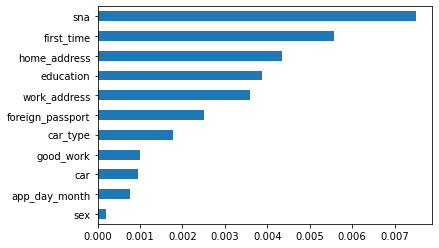

In [42]:
imp_cat = pd.Series(mutual_info_classif(data_default[bin_cols + cat_cols], data_default['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Подготовка данных для ML model

In [44]:
data[cat_cols].nunique()

education        6
home_address     3
work_address     3
sna              4
first_time       4
app_day_month    4
dtype: int64

In [45]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [46]:
X_cat.shape

(110148, 24)

In [47]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[num_cols].values)
X_num

array([[-0.41881524, -0.73558697, -0.43953103,  0.77056313,  0.68042509],
       [ 4.53998904,  0.80003948, -0.43953103,  0.33379697, -2.6246238 ],
       [-0.41881524,  0.42690838, -0.43953103, -0.28179035, -0.05283405],
       ...,
       [-0.41881524,  0.78474991,  1.61380664,  1.10934528,  0.52918572],
       [-0.41881524,  0.85143237, -0.43953103,  0.77056313, -1.25318603],
       [-0.41881524,  0.27998625, -0.43953103,  0.33379697, -0.31454282]])

## Тренируем модель Логистической регрессии

In [48]:
# Завернем всю предобработку параметров для подачи в модель в функцию
def df_to_model_input(data, cat_cols, bin_cols, num_cols):
    ec = OneHotEncoder(sparse = False)
    X_cat = ec.fit_transform(data[cat_cols].values)
    X_num = StandardScaler().fit_transform(data[num_cols].values)
    X = np.hstack([X_num, data[bin_cols].values, X_cat])
    Y = data['default'].values    
    return X, Y, [num_cols + bin_cols + ec.get_feature_names(cat_cols).tolist()][0]

Разделим датасет на исходные пакеты train и test

In [49]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

Разделяем наш train на обучающую и тестовую части

In [50]:
X, Y, col = df_to_model_input(train_data, cat_cols, bin_cols, num_cols)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [51]:
# Функция для тренировки модели Логистической регрессии
def train_model(X, Y):
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    return model

# Функция оценки качества модели методом ROC-анализа
def quality_control_model(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

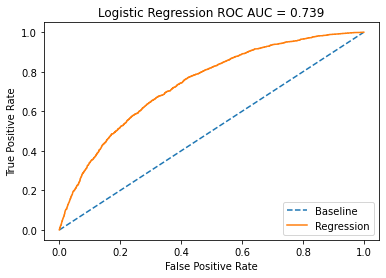

In [52]:
# Обучаем нашу модель и выводим ее оценку качества на данных train
model = train_model(X_train, y_train)
quality_control_model(model, X_test, y_test)

### Поиск гиперпараметров GridSearchCV

In [53]:
model_other = LogisticRegression(multi_class='ovr', class_weight='balanced', solver='liblinear',random_state=40)
param_grid = [{'penalty':['l1'], 'C':[0.1, 1, 10], 'max_iter':[1000], 'tol':[1e-5]},
             {'penalty':['l2'], 'C':[0.1, 1, 10], 'max_iter':[1000], 'tol':[1e-5]},
             {'penalty':['none'], 'max_iter':[1000], 'tol':[1e-5]},]

# Создаем сетку поиска
gridsearch = GridSearchCV(model_other, param_grid, scoring='f1', n_jobs=-1, cv=5)

best_model = gridsearch.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 0.1


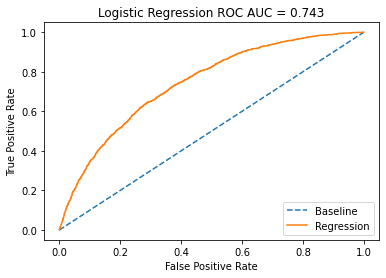

In [54]:
quality_control_model(best_model, X_test, y_test)

## Submission

In [53]:
test_data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_day_month
18776,75368,2014-03-23,0,0,3.737670,0,0,1.098612,0,-1.526461,1.386294,4.110874,1,2,9.392745,4,1,0,-1,3
22277,33344,2014-02-09,1,1,3.433987,1,1,0.000000,0,-2.446853,1.098612,4.394449,3,3,10.596660,1,3,1,-1,2
2934,82979,2014-03-31,0,0,3.091042,0,0,1.098612,0,-1.247931,0.693147,4.394449,2,3,10.308986,1,4,0,-1,3
15111,59468,2014-03-08,0,1,3.218876,0,0,0.000000,1,-2.030046,0.693147,3.931826,1,2,10.126671,4,1,0,-1,3
33030,51155,2014-02-27,0,0,3.218876,0,0,0.000000,0,-1.774403,0.000000,3.931826,1,2,9.615872,1,4,0,-1,2


In [54]:
X, Y, fn = df_to_model_input(test_data, cat_cols, bin_cols, num_cols)

predict_submission = model.predict_proba(X)[:,1]

### Convert to the expected output

In [55]:
sample_submission.sample(3)

,client_id,default
4647,44636,0.688076
12990,70086,0.192000
20544,12165,0.142754


In [56]:
submission = pd.DataFrame()
submission["client_id"] = test_data.client_id
submission["default"] = predict_submission
submission.sample(10)

,client_id,default
10132,15043,0.048906
15554,69571,0.141970
16927,25768,0.144150
21771,35421,0.219775
8942,9909,0.070527
26654,70897,0.114890
29643,50631,0.335521
16327,23592,0.153644
10977,69442,0.042759
23836,66167,0.130826


### Save resuts for submission

In [57]:
submission.to_csv('submission.csv', index=False)